In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.linalg import svd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder,  StandardScaler
from matplotlib.pyplot import (figure, plot, title, xlabel, ylabel, 
                               colorbar, imshow, xticks, yticks, show)
from sklearn import model_selection, tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, DistanceMetric
import numpy as np

## Import file

In [19]:
# Load the heart csv data using the Pandas library
filename = 'heart.csv'
df = pd.read_csv(filename)


In [20]:
# Select columns 1 to 18
selected_columns = df.iloc[:, 0:18]

# Calculate basic summary statistics
summary_statistics = selected_columns.describe()

# Display the summary statistics
print(summary_statistics)

                 BMI  PhysicalHealth   MentalHealth      SleepTime
count  319795.000000    319795.00000  319795.000000  319795.000000
mean       28.325399         3.37171       3.898366       7.097075
std         6.356100         7.95085       7.955235       1.436007
min        12.020000         0.00000       0.000000       1.000000
25%        24.030000         0.00000       0.000000       6.000000
50%        27.340000         0.00000       0.000000       7.000000
75%        31.420000         2.00000       3.000000       8.000000
max        94.850000        30.00000      30.000000      24.000000


In [21]:
# drop the data set
df = df.drop(df[(df.BMI > summary_statistics.BMI['mean']+2*summary_statistics.BMI['std'])
            & (df.BMI < summary_statistics.BMI['mean']-2*summary_statistics.BMI['std'])
            & (df.PhysicalHealth > summary_statistics.PhysicalHealth['mean']+2*summary_statistics.PhysicalHealth['std'])
            & (df.PhysicalHealth < summary_statistics.PhysicalHealth['mean']-2*summary_statistics.PhysicalHealth['std'])
            & (df.MentalHealth > summary_statistics.MentalHealth['mean']+2*summary_statistics.MentalHealth['std'])
            & (df.MentalHealth < summary_statistics.MentalHealth['mean']-2*summary_statistics.MentalHealth['std'])
            & (df.SleepTime > summary_statistics.SleepTime['mean']+2*summary_statistics.SleepTime['std'])
            & (df.SleepTime < summary_statistics.SleepTime['mean']-2*summary_statistics.SleepTime['std'])].index)

In [24]:
# Count the number of 'yes' and 'no' values in the 'label' column
yes_count = df['HeartDisease'].value_counts()['Yes']
no_count = df['HeartDisease'].value_counts()['No']


# Determine the label to balance (either 'yes' or 'no')
label_to_balance = 'Yes' if yes_count > no_count else 'No'
label_to_keep = 'Yes' if yes_count <= no_count else 'No'

# Calculate the difference in counts
count_diff = yes_count 

# Get the columns where the label is equal to label_to_balance
columns_to_balance = df[df['HeartDisease'] == label_to_balance]

# Randomly sample rows to make the counts equal
sampled_rows = columns_to_balance.sample(n=count_diff, random_state=42)

# Concatenate the sampled rows with the rows where the label is equal to label_to_keep
balance = pd.concat([df[df['HeartDisease'] == label_to_keep], sampled_rows])

# Shuffle the rows to randomize the order
balance = balance.sample(frac=1, random_state=42)

df = balance 


print(len(df))

54746


In [27]:
# Transforme the discrete string into integer
encoder = LabelEncoder()
for col in df:
  if col != "BMI":
    df[col] = encoder.fit_transform(df[col])

In [28]:
# Extract the data matrix, the class label and attribute names from the csv
raw_data = df.values

Data = raw_data[:,1:]
Label = df.values [:,0]
Attributes = np.asarray(df.columns[1:].str.slice(0, 3))

In [30]:
# Summary of Dataset in percentages
print(df['HeartDisease'].value_counts(normalize=True) * 100)


1    50.0
0    50.0
Name: HeartDisease, dtype: float64


In [31]:
# Assign each type of class with a number by making a Python dictionary
# and extract the class vector y, convert to NumPy array
classNames = np.unique(Label)
classDict = dict(zip(classNames,range(len(classNames))))

y = np.asarray([classDict[value] for value in Label])

In [32]:
# Compute values of number of data(N), attributes(M) and classes(C).
N = len(y)
M = len(Attributes)
C = len(classNames)

In [33]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(Data,Label,test_size=0.8)
print(X_train)

[[23.48  1.    0.   ...  0.    0.    0.  ]
 [36.58  1.    0.   ...  0.    0.    0.  ]
 [27.46  1.    0.   ...  0.    0.    0.  ]
 ...
 [26.45  0.    0.   ...  0.    0.    0.  ]
 [31.57  0.    0.   ...  0.    0.    1.  ]
 [28.59  1.    0.   ...  0.    0.    0.  ]]


In [14]:
# # Plot the training data points (color-coded) and test data points.
# figure(1)
# styles = ['.b', '.r', '.g', '.y']
# for c in range(C):
#     class_mask = (y_train==c)
#     print(class_mask)
#     plot(X_train[class_mask,0], X_train[class_mask,1], styles[c])


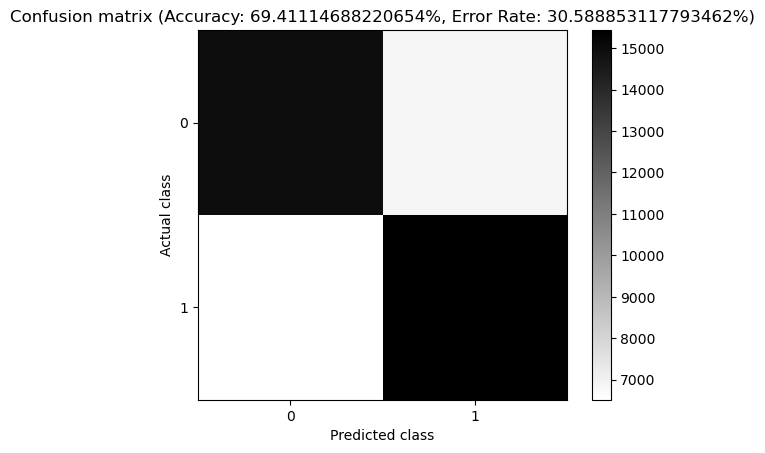

Ran Exercise 6.3.1


In [13]:
K=3

# Distance metric (corresponds to 2nd norm, euclidean distance).
# You can set dist=1 to obtain manhattan distance (cityblock distance).
dist= 2
#metric = 'minkowski'
#metric_params = {} # no parameters needed for minkowski

# You can set the metric argument to 'cosine' to determine the cosine distance
metric = 'cosine' 
metric_params = {} # no parameters needed for cosine

# To use a mahalonobis distance, we need to input the covariance matrix, too:
#metric='mahalanobis'
#metric_params={'V': cov(X_train, rowvar=False)}

# Fit classifier and classify the test points
knclassifier = KNeighborsClassifier(n_neighbors=K, p=dist, 
                                    metric=metric,
                                    metric_params=metric_params)
knclassifier.fit(X_train, y_train)
y_est = knclassifier.predict(X_test)


# # Plot the classfication results
# styles = ['ob', 'or', 'og', 'oy']
# for c in range(C):
#     class_mask = (y_est==c)
#     plot(X_test[class_mask,0], X_test[class_mask,1], styles[c], markersize=10)
#     plot(X_test[class_mask,0], X_test[class_mask,1], 'kx', markersize=8)
# title('Synthetic data classification - KNN');

# Compute and plot confusion matrix
cm = confusion_matrix(y_test, y_est);
accuracy = 100*cm.diagonal().sum()/cm.sum(); error_rate = 100-accuracy;
figure(2);
imshow(cm, cmap='binary', interpolation='None');
colorbar()
xticks(range(C)); yticks(range(C));
xlabel('Predicted class'); ylabel('Actual class');
title('Confusion matrix (Accuracy: {0}%, Error Rate: {1}%)'.format(accuracy, error_rate));

show()
